In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l
import logging

In [2]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    csv_data = pd.read_csv('./data/banana-detection/bananas_train/label.csv')

    #设置索引列
    csv_data = csv_data.set_index('img_name')
    
    images, targets = [], []
    for img_name, target in csv_data.iterrows():

        #所有图像
        images.append(torchvision.io.read_image(os.path.join('./data/banana-detection/bananas_train/images', img_name)))

        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))

    # unsqueeze(1)： 添加一个维度
    # / 256：对标签进行归一化，通常图像的尺寸为 256x256，归一化后边界框的坐标值在 [0, 1] 之间。
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [3]:
class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""
    def __init__(self, is_train):
        # self.features 图像张量
        # self.labels 图像标签
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    # 根据索引获取单个样本
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    # 返回数据集的大小
    def __len__(self):
        return len(self.features)

In [4]:
def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""

    # 加载训练集的 DataLoader
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)

    # 加载验证集的 DataLoader                                         
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [5]:
# 每个批次包含32张图片，图片的边长为256像素
batch_size, edge_size = 32, 256

# 加载数据集
train_iter, _ = load_data_bananas(batch_size)

# iter(train_iter)将数据加载器转换为迭代器
# next()获取迭代器的下一个元素,即一个批次的数据
batch = next(iter(train_iter))

"""
batch[0].shape: 图像数据的形状是[32, 3, 256, 256]
32: 批次大小
3: RGB三个颜色通道
256, 256: 图片的高度和宽度
"""
"""
batch[1].shape: 标签数据的形状是[32, 1, 5]
32: 批次大小
1: 每张图片只有一个边界框
5: 每个边界框的5个值(类别, x1, y1, x2, y2)
"""
batch[0].shape, batch[1].shape

read 1000 training examples
read 1000 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

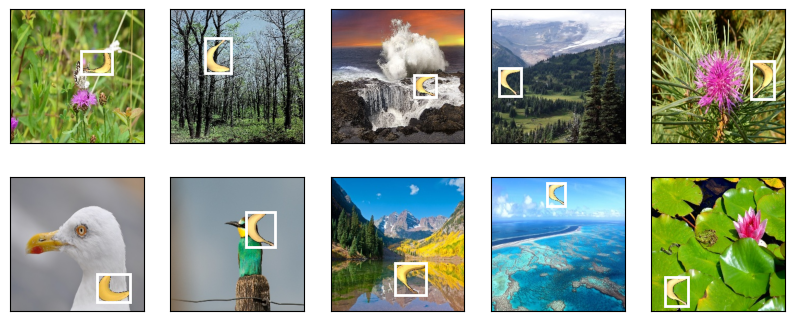

In [10]:

# batch[0][0:10]: 从批次中选取前10张图片
# permute(0, 2, 3, 1): 调整图像数据的维度顺序，从(batch_size, channels, height, width)变为(batch_size, height, width, channels)
# / 255: 将像素值从0-255归一化到0-1范围
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255

# 将10张图像排列成2行5列
# scale=2设置显示的缩放比例（2倍大小显示）
# axes所有子图对象（父图就是所有图像组成的整体）
axes = d2l.show_images(imgs, 2, 5, scale=2)

# batch[1][0:10]: 前10张图片对应的标签数据
for ax, label in zip(axes, batch[1][0:10]):
    # 在每张图片上绘制边界框
    # label[0][1:5]: 获取标签中的边界框坐标(x1,y1,x2,y2)
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])